# Attractor Neural Network
## Amari-Hopfield Network
Let's begin from studying the one of the most classic attractor neural network model -- **Amari-Hopfield Network**.

This network consists of $N$ neurons, each state is denoted as **$S_i (i=1,2,...,N)$**. This model assumes the neuron can only be at **two binary states, i.e., $S_i = +1 / -1$**, representing the neuron can only be either activated or silenced at one time. The neurons are recurrently connected with each other, the connection strength can be expressed as a matrix **$W$**. 
The update rule of the network is expressed as,
$$S_i(t+1) = sign(\sum_{j=1}^N W_{ij}S_j(t) - \theta)$$
where $\sum_{j=1}^N W_{ij}S_j(t)$ represents the total recurrent input current the $i_{th}$ neuron receives at time $t$, which in turn determines the neuron state in the next time. Specifically, if the recurrent input exceeds a certain threshold $\theta$, the neuron state $S_i=1$, otherwise $S_i = -1$.
It should be noted that, the update of different neurons are asynchoronous, which means that at each time only one neuron state will change.

Amari and Hopfield proved that, to store $n$ different **patterns $\xi^\mu (\mu = 1,2,...n)$** as attractor states in this network, the synaptic weights between i-th an j-th neuron $W_{ij}$ should be:
$$W_{ij} = \sum_{\mu=1}^n \xi_i^\mu \xi_j^\mu$$
where $W_{ii}=0$, representing that neurons do not connect with itself.

The energy function $E$ is expressed as,
$$ E = -\frac{1}{2} \sum_{i,j}W_{ij} S_i S_j + \theta \sum_i S_i

The raw version is written by brainpy. you can find the original codes``. But i'm not the user of brainpy so as i choose the numpy for implement.

## Costomize Amari-Hopfield Network
This is a discrete version only receiving the -1/+1 values as the input

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.integrate import odeint
from copy import deepcopy

In [ ]:
class HopfieldNetwork:
    def __init__(self, num):
        self.num = num
        self.weights = np.zeros((num, num))
    
    # Storing one sample pattern 
    def store(self, pattern):
        """Store a sample pattern in the Hopfield network.
        
        @param pattern: The sample pattern to store.
        """
        # sample is an array with the shape of (N,)
        assert self.num == pattern.shape[0]

        # Data cross-product gives neural hopfield update rule.
        w_update = np.outer(pattern, pattern)

        # Sum all pattern cross-products.
        self.weights += w_update
    
    # training the network
    def store_patterns(self, patterns):
        """Store multiple patterns in the Hopfield network.
        
        @param patterns: A list of sample patterns to store, shaped [n, N]. n is the number of patterns and N is the number of neurons. 
        """
        assert patterns.ndim == 2
        assert patterns.shape[1] == self.num
        for pattern in patterns:
            self.store(pattern)
        
        # Hopfield nets are a form of RNNs, albeit without self-connections, and so,
        # we need to make sure that the diagonal elements of the final weight matrix are zero.
        np.fill_diagonal(self.weights, 0)
     
    def async_recover(self, pattern, steps=10, energy=False):
        """Asynchronous update of the Hopfield network.
        
        @param pattern: The initial pattern to start the update from.
        @param steps: The number of update steps to perform.
        @param energy: If True, return the energy of the pattern after the update.
        """
        idx = np.random.randint(0, self.num, steps)
        energy_list = []
        assert pattern.shape[0] == self.num
        pattern = deepcopy(pattern) # used to avoid modifying the original pattern in the numpy
        def recover(i):
            # Update the neuron using the sign of the weighted sum of inputs
            pattern[i] = np.sign(np.dot(self.weights[i], pattern))
            if energy:
                return self.energy(pattern)
        
        for i in tqdm(idx):
            r = recover(i)
            if energy:
                energy_list.append(r)
        
        return (pattern, energy_list) if energy else pattern
    
    def energy(self, pattern):
        """Calculate the energy of the current pattern. 
        
        @param pattern: The current pattern.
        """
        assert pattern.shape[0] == self.num
        return -0.5 * np.dot(pattern, np.dot(self.weights, pattern))

## Simulating the Amari-Hopfield Network
Now let us test its ability to store patterns and steadily retrieve it as attractor states!
### Data for testing
Now we are going to load the data in. We have already saved off two images, a ‘9’ and a ‘4’, to keep things simple for us. We also reshape them into their native [28 x 28] size, so that we can later corrupt them in this domain, and then reconstruct them.

The data can be downloaded in this url: https://github.com/brainpy/examples/blob/main/attractors/data/data_to_train_on.npy

In [73]:
data = (np.load('data/data_to_train_on.npy')).astype(np.float32)

data.shape

(2, 784)

What does our data look like? Well they are just two binary images, showing a figure ‘9’, and a figure ‘4’. Let’s image them just to take a peek at what they look like.

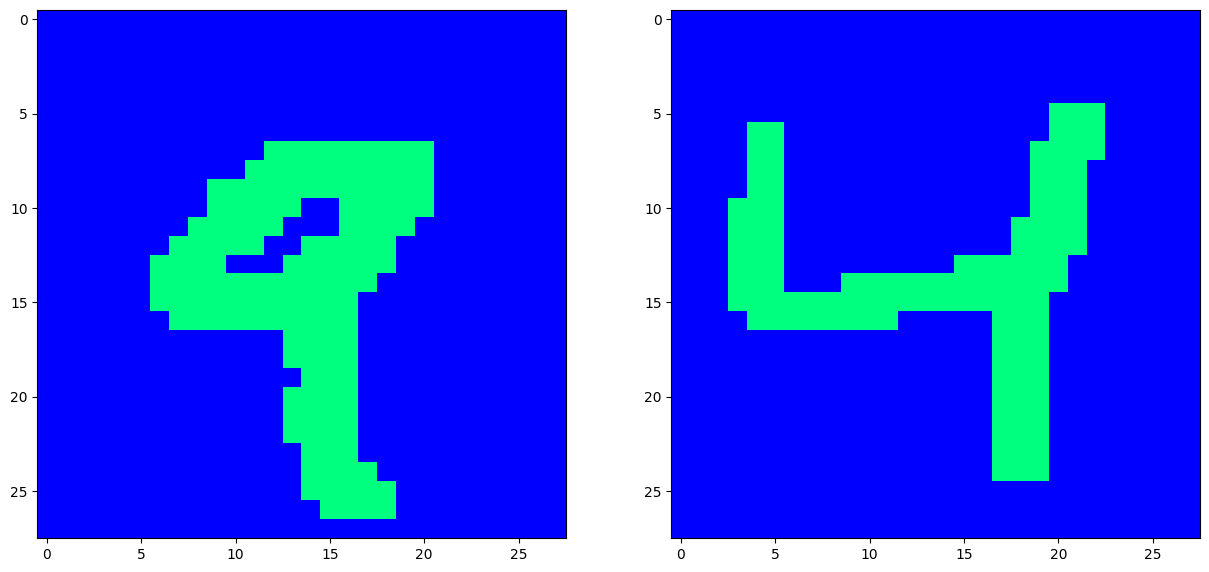

In [74]:
# Show the training data - it's just two different samples that we are going to want the Hopfield net to store.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7.5))
ax[0].imshow(data[0].reshape(28, 28), interpolation='None', cmap='winter')
ax[1].imshow(data[1].reshape(28, 28), interpolation='None', cmap='winter')
plt.show()

We will use this function to take in a good image, and corrupt it, based on two types of noise, either bernouli noise, (where every pixel is randomly flipped in sign), or masking noise, where we blot out entire sections of the image. Our Hopfield net will be able to recover the original image via energy minimization as we will see.

In [3]:
def add_bernouli_noise(img, prob=0.1, mask_value=1.):
    rand = np.random.rand(*img.shape) < prob
    return np.where(rand, mask_value, img)
def add_mask_noise(img, mask_value=-1, mask_matrix=np.zeros((2,2))):
    img = np.copy(img)
    img[mask_matrix[0,0]: mask_matrix[0,1], mask_matrix[1,0]: mask_matrix[1,1]] = mask_value
    return img

### Training
OK this is where the fun begins! We are now going to train our Hopfield net. The objective is simple: We want it to store those two patterns we are feeding it, such that a faithful reconstruction can be performed, when corrupted versions of either of those inputs is given later in the future.

In [76]:
# Train the Hopfield net!

# So there are as many neurons as pixels per pattern, and this is what this computes.
net = HopfieldNetwork(num=data.shape[1])

# Great - we are all set - now we train!
net.store_patterns(data)

Now at this point, we have a trained weight matrix, encoded with the pattern ‘4’ and pattern ‘9’. (We will see later on that Hopfield nets aren’t that memory efficient, but it’s still amazing what they are capable of). Now remember - the objective here is simple: We want it to store those two patterns we are feeding it, such that faithful reconstruction can later be performed, when corrupted versions of either of those inputs are presented. But does it work? Let’s find out!).

### Testing
We can corrupt our data in many ways - and here, we can add two types of noise: Bernouli noise, (where every pixel is flipped in sign with a certain probability) and/or masking noise, (where we simply blot out certain regions with one particular sign).

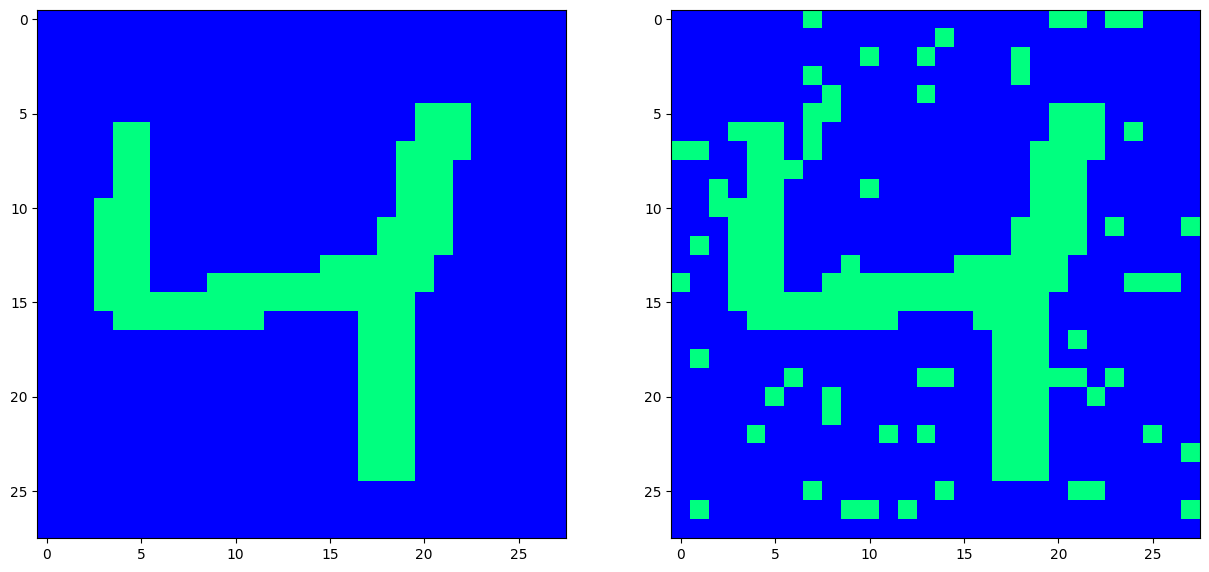

In [77]:
# Let's pick one the image '4', and corrupt it.
image = data[1]

# Corrupt the image with bernouli noise.
corrupted_image = add_bernouli_noise(image, prob=0.1)

# Let's see the original image, as well as the corrupted version.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7.5))
ax[0].imshow(image.reshape(28, 28), interpolation='None', cmap='winter')
ax[1].imshow(corrupted_image.reshape(28, 28), interpolation='None', cmap='winter')
plt.show()

100%|██████████| 5000/5000 [00:00<00:00, 31307.74it/s]


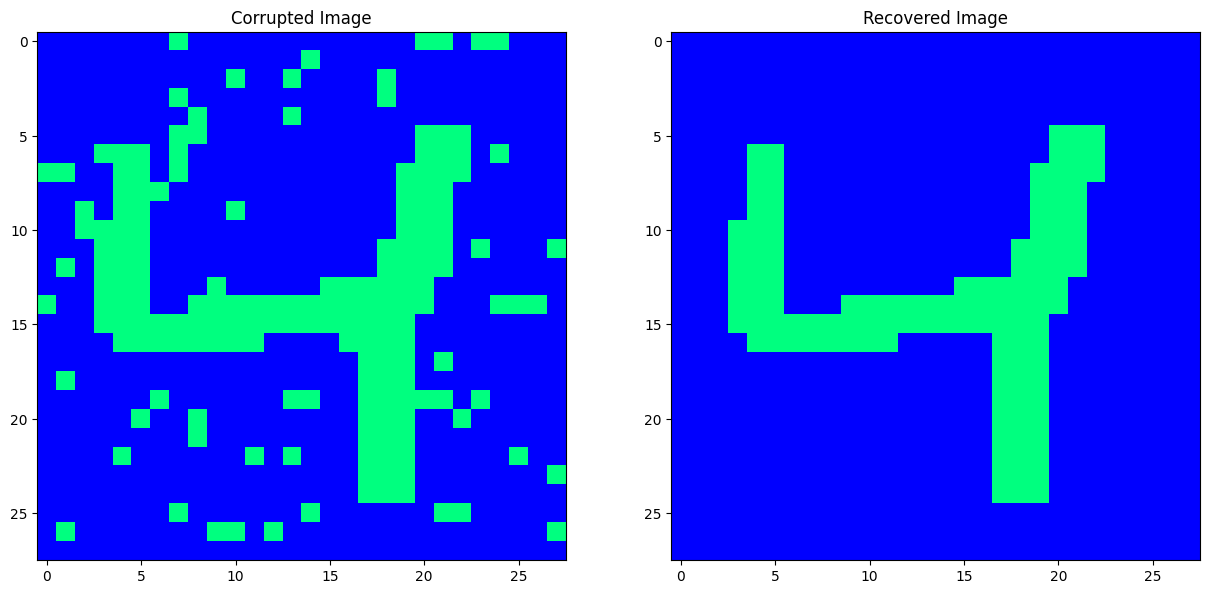

In [78]:

# The number of iterations where we randomly update neurons/pixels
n_iterations = 5000

# Loop through, and recover the image from it's corrupted self.
# energy_vec: This will store the energy of the Hopfield net.
cleaned_image, energy_vec = net.async_recover(corrupted_image, n_iterations, True)

# (For imaging purposes)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 7.5))
ax[0].imshow(corrupted_image.reshape(28, 28), interpolation='None', cmap='winter')
ax[0].set_title('Corrupted Image')
ax[1].imshow(cleaned_image.reshape(28, 28), interpolation='None', cmap='winter')
ax[1].set_title('Recovered Image')
plt.show()

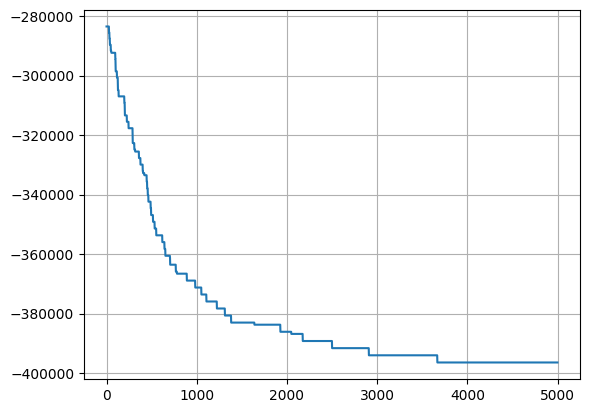

In [63]:
# Plot the Hopfield energy during recovery
plt.plot(energy_vec)
plt.grid('on')
plt.show()

Our original pattern has been very nicely recovered. What about masking noise and bernouli noise? 

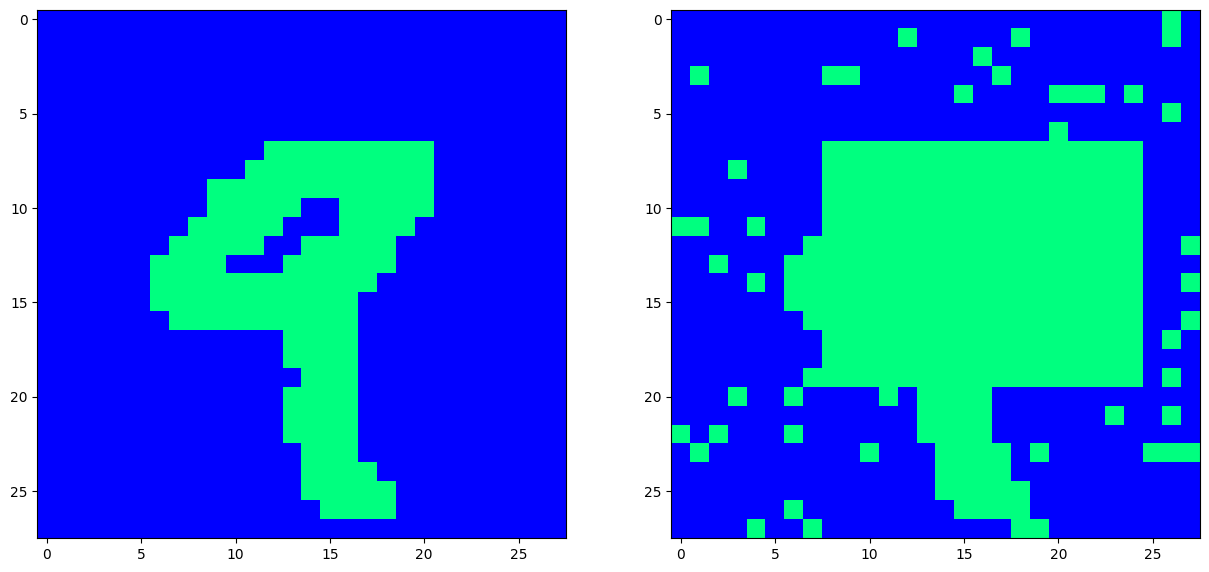

In [64]:
# Masking and Bernouli noise
mask_matrix = np.asarray([[7, 20], [8, 25]], dtype=np.int32)

image = data[0].reshape(28, 28)
corrupted_image = add_mask_noise(image, mask_value=1, mask_matrix=mask_matrix)
corrupted_image = add_bernouli_noise(corrupted_image, prob=0.1)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7.5))
ax[0].imshow(image, interpolation='None', cmap='winter')
ax[1].imshow(corrupted_image, interpolation='None', cmap='winter')
plt.show()

100%|██████████| 5000/5000 [00:00<00:00, 27150.16it/s]


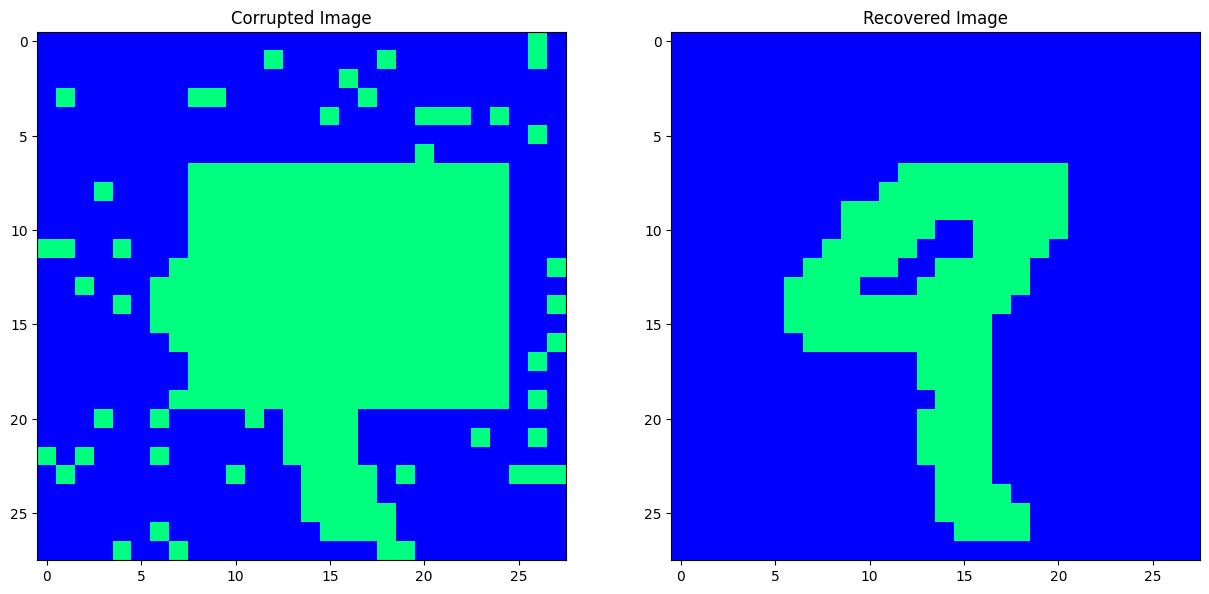

In [66]:
# The number of iterations where we randomly update neurons/pixels
n_iterations = 5000

# Loop through, and recover the image from it's corrupted self.
# energy_vec: This will store the energy of the Hopfield net.
corrupted_image = corrupted_image.flatten()
cleaned_image, energy_vec = net.async_recover(corrupted_image, n_iterations, True)

# (For imaging purposes)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 7.5))
ax[0].imshow(corrupted_image.reshape(28, 28), interpolation='None', cmap='winter')
ax[0].set_title('Corrupted Image')
ax[1].imshow(cleaned_image.reshape(28, 28), interpolation='None', cmap='winter')
ax[1].set_title('Recovered Image')
plt.show()

# Modern Hopfield Network
The traditional Hopfield network has a lot of limits as a memory storage system, including its limited capacity and the lack of ability for representing continuous variables.

To overcome these limits, "modern Hopfield Network" is proposed. In contrast with the traditional Hopfield Network, Modern Hopfield is two-layerd network.

Notations: 
- external input of visible neurons, $I_i(t)$; 
- synaptic input of visible neurons, $v_i(t)$; 
- firing rate of visible neurons, $g(v_i(t))$; 
- synaptic input of hidden neurons, $h_{\mu}(t)$; 
- firing rate of visible neurons, $f(h_{\mu}(t))$; 

The dynamics of the network is given by:

$$ \tau_f \frac{dv_i(t)}{dt} = -v_i(t)+\sum_{\mu=1}^{N_h} \xi_{i, \mu}f(h_{\mu}(t))+I_i(t)$$ 
$$ \tau_h \frac{dh_{\mu}(t)}{dt} = -h_{\mu}(t)+\sum_{i=1}^{N_f} \xi_{\mu, i}g(v_{i}(t))$$ 

The general form of energy fucntion is given by:

$$ E(t) =  \left[\sum_{i=1}^{N_f}(x_i(t)-I_i(t))g_i(x_i(t)) - L_v(f_i(t))\right] + \left[\sum_{\mu=1}^{N_h}h_\mu(t) f_\mu(t) - L_h(h_\mu(t))\right] - \sum_{\mu, i} f(h_{\mu}(t))\xi_{\mu, i}g(v_{i}(t))$$ 
where $L_h$ and $L_v$ represents two Larangian functions of the activation function, which is given by:
$$f_\mu = \frac{\partial L_\mu}{\partial h_\mu},        g_i = \frac{\partial L_v}{\partial v_i} $$

# Costomize a Modern Hopfield Network
Here we assume that the Lagrangian fucntions take the form,
$$L_\mu = log\left(\sum_{\mu} e^{h_\mu} \right),        L_v = \frac{1}{2}\sum_{i}v_i^2 $$
which gives,
$$f_\mu(h) = softmax(h_\mu) = \frac{e^{h_\mu}}{\sum_{\mu}e^{h_\mu}}  ,        g_i(v) = v_i $$

In [55]:
class ModernHopfieldNetwork:
    def __init__(self, Patterns, tau_f=100., tau_h=1., dt=0.04):
        # visible and hidden neurons
        self.num_f = Patterns.shape[1]  
        self.num_h = Patterns.shape[0] 
        
        # time constants
        self.tau_f = tau_f
        self.tau_h = tau_h
        self.dt = dt
        
        # connnection matrix
        self.conn_mat = Patterns.copy()
        
        # neurons activation
        self.v = np.zeros(self.num_f) 
        self.g = np.zeros(self.num_f)  
        
        # neurons state
        self.h = np.zeros(self.num_h)  
        self.f = np.zeros(self.num_h)  
        self.E = 0.0  
    
    def derivation(self, state, t, I_ext):
        """Calculate the derivatives of the network state."""
        # state variable is a concatenation of v and h
        v = state[:self.num_f]
        h = state[self.num_f:]
        
        # 计算激活函数
        self.f = self.softmax(h)
        self.g = v.copy()
        
        # gradients
        dv_dt = (-v + np.dot(self.conn_mat.T, self.f) + I_ext) / self.tau_f
        dh_dt = (-h + np.dot(self.conn_mat, self.g)) / self.tau_h
        
        return np.concatenate([dv_dt, dh_dt])
        
    def integrate(self, I_ext, t_span):
        """Integrate the network state over time.
        
        @param I_ext: External input to the network.
        @param t_span: Time span for the integration.
        """
        initial_state = np.concatenate([self.v, self.h])
        solution = odeint(self.derivation, initial_state, t_span, args=(I_ext,))
        
        # Update the state variables
        final_state = solution[-1]
        self.v = final_state[:self.num_f]
        self.h = final_state[self.num_f:]
        
        return solution
        
    def softmax(self, x):
        x = x - np.max(x)  # for numerical stability
        exp_x = np.exp(x)
        return exp_x / np.sum(exp_x)

    def activation(self):
        self.f = self.softmax(self.h)
        self.g = self.v.copy()
    
    def initialize(self, sample):
        """Initialize the network with a sample pattern.
        
        @param sample: The sample pattern to initialize the network with.
        """
        assert sample.shape[0] == self.num_f
        self.v = sample.copy()
        self.g = self.v.copy()
        self.h = np.dot(self.conn_mat, self.g)
        self.f = self.softmax(self.h)
    
    # net's energy calculation
    def energy(self):
        """Calculate the energy of the current state of the network."""
        h_max = np.max(self.h)
        exp_h = np.exp(self.h - h_max)
        v_squared = np.square(self.v)
        self.E = 0.5 * np.sum(v_squared) - h_max - np.log(np.sum(exp_h))
        return self.E
    
    def update(self, input, duration=0.10):
        """Update the network state based on the input.
        
        @param input: The input pattern to update the network with.
        @param duration: Duration of the update step.
        """
        self.activation()
        
        # Create time span for integration
        t_span = np.linspace(0, duration, int(duration/self.dt) + 1)
        
        # Integrate the system
        _ = self.integrate(input, t_span)
        
        # Calculate energy
        energy = self.energy()
        
        return self.v.copy(), energy
    
    def step(self, input, times = 2000):
        """Perform multiple update steps on the network.
        
        @param input: The input pattern to update the network with.
        @param times: Number of update steps to perform.
        """
        v_list = []
        energy_list = []
        for _ in tqdm(range(times)):
            v, energy = self.update(input)
            v_list.append(v)
            energy_list.append(energy)

        return v_list, energy_list


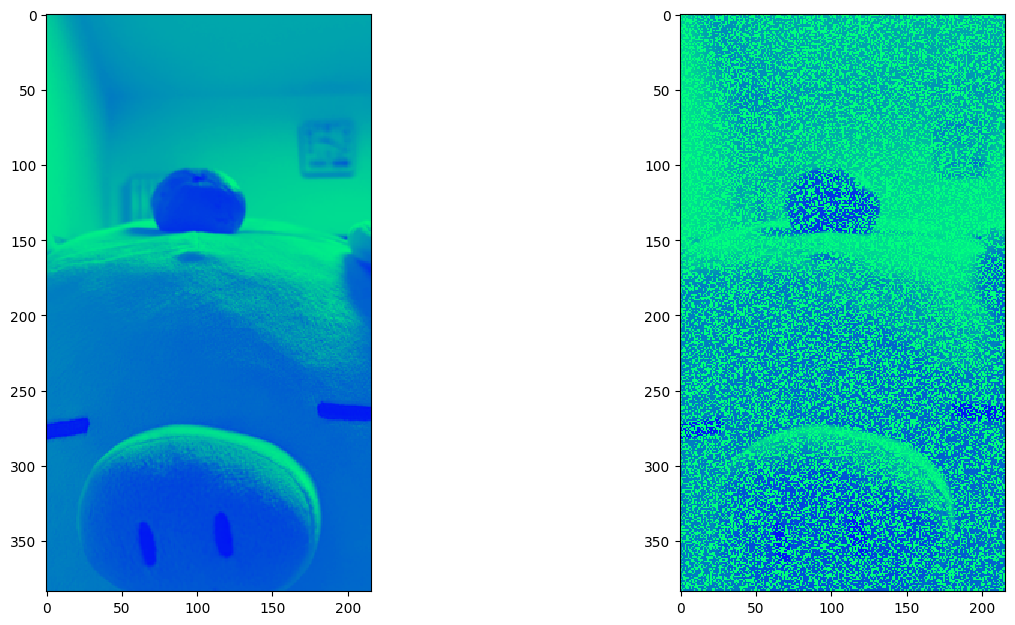

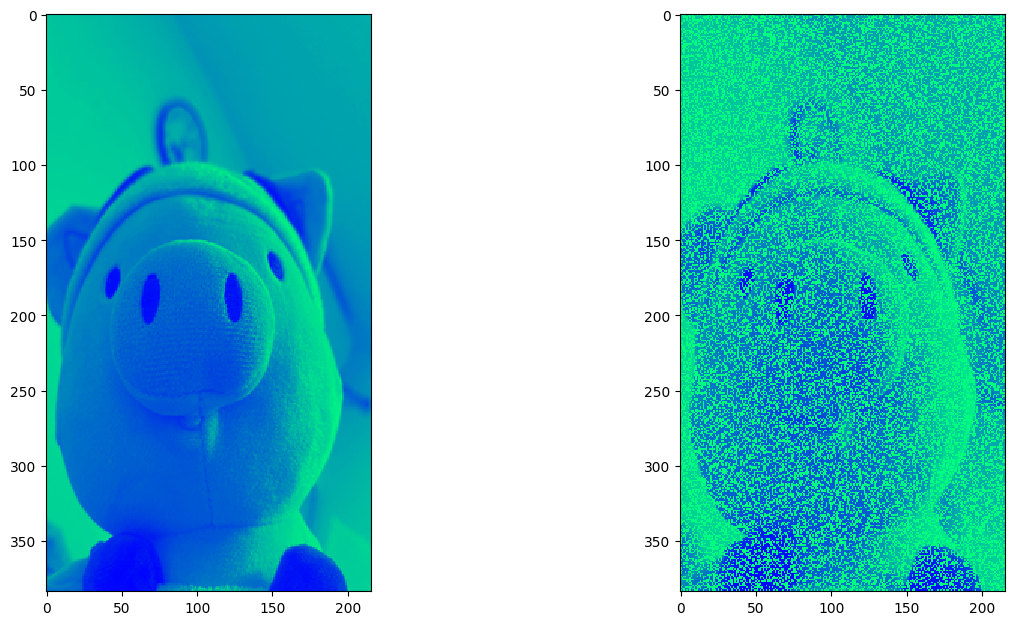

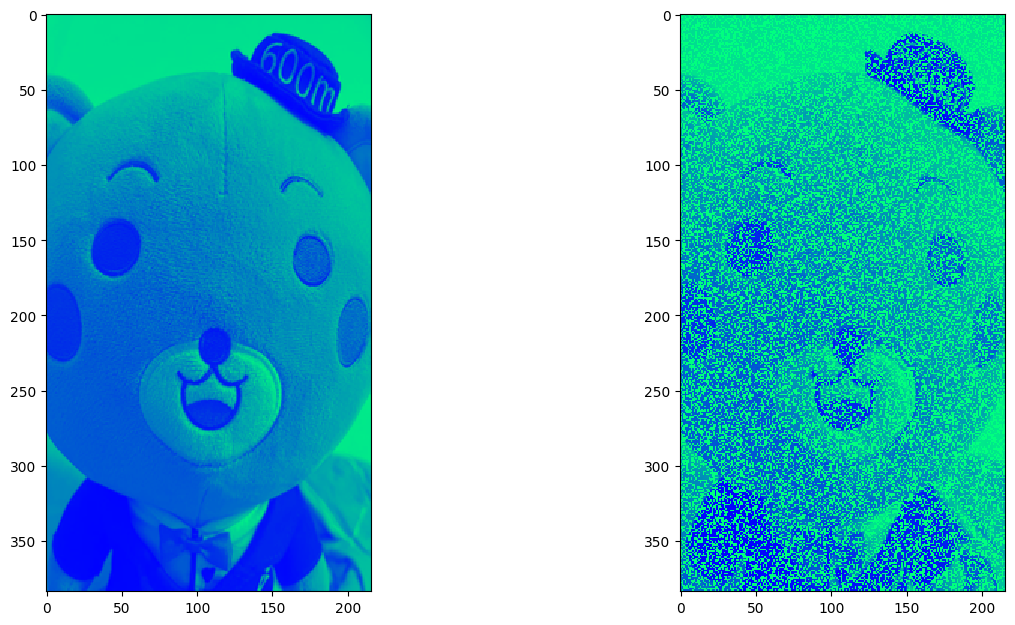

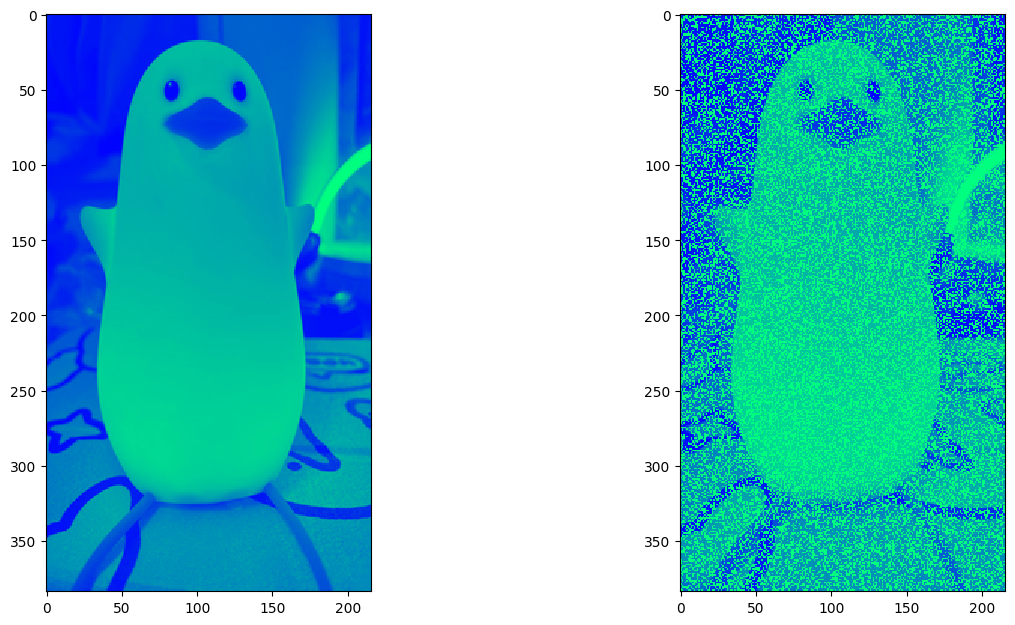

In [57]:
from PIL import Image
# 打开原始图像
n_image = 4
n1 = 192*2
n2 = 108*2
data = np.zeros([n_image, n1 * n2])
image = np.zeros([n_image, n1, n2])
corrupted_image = np.zeros([n_image, n1, n2])
for i in range(n_image):
    original_image_path = 'data/bro_' + str(i+1) +  '.jpg'
    original_image = Image.open(original_image_path)
    # Downsampling
    resized_image = original_image.resize((n2, n1), Image.LANCZOS)
    # 将降采样后的图像转换为NumPy数组
    array_image = np.array(resized_image)
    resized_image_array = array_image/256
    image[i] = np.mean(resized_image_array, axis=2)
    data[i] = image[i].reshape([1,-1])
    corrupted_image[i] = add_bernouli_noise(image[i], prob=0.4)

retrieve_idxs = np.array([0, 1, 2, 3])
for retrieve_idx in retrieve_idxs:
    # Initialize the Modern Hopfield Network

    # Let's see the original image, as well as the corrupted version.
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7.5))
    ax[0].imshow(image[retrieve_idx], interpolation='None', cmap='winter', vmin = np.min(image), vmax = np.max(image))
    ax[1].imshow(corrupted_image[retrieve_idx], interpolation='None', cmap='winter', vmin = np.min(image), vmax = np.max(image))


### run the net

In [58]:
net = ModernHopfieldNetwork(Patterns=data)
sample = corrupted_image[retrieve_idx].reshape(-1,)
net.initialize(sample=sample)

100%|██████████| 2000/2000 [00:06<00:00, 287.96it/s]


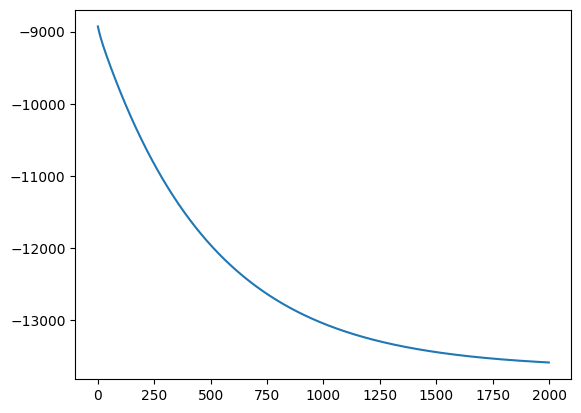

In [59]:
V_trace, E_trace = net.step(input=0)
plt.plot(E_trace)

In [71]:
len(V_trace)
V_trace[0].shape

(82944,)

Text(0.5, 1.0, 'recoverd image')

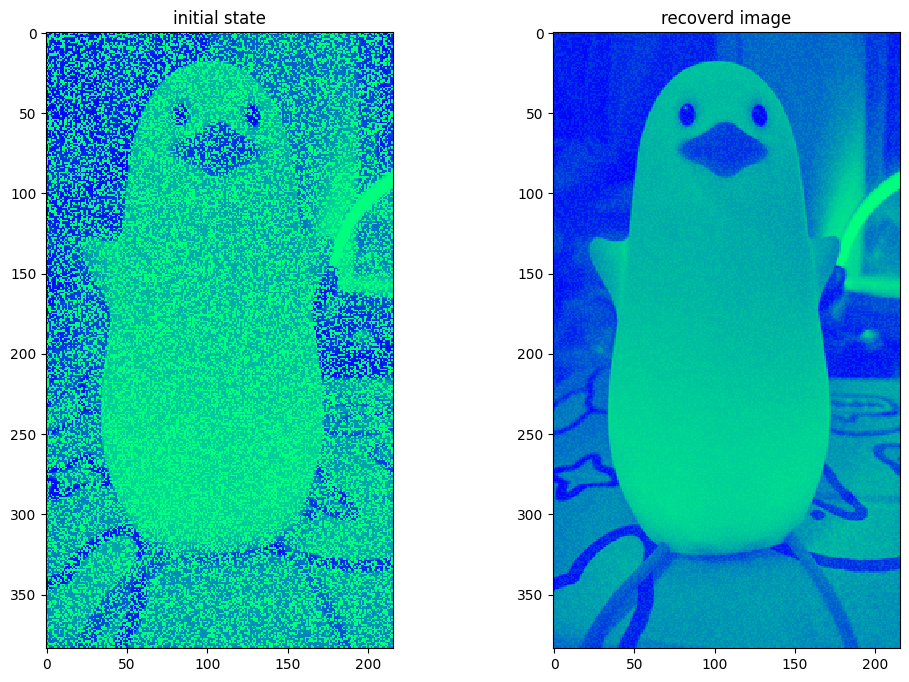

In [74]:
from matplotlib.animation import FuncAnimation
fps = 30
n_step = 20
# 动画化网络活动\
raw_pic = V_trace[0].reshape(n1, n2)
final_pic = V_trace[-1].reshape(n1, n2)

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(1,2,figsize=(12,8))
ax[0].imshow(raw_pic, interpolation='None', cmap='winter', vmin = np.min(image), vmax = np.max(image))
ax[0].set_title('initial state')
ax[1].imshow(final_pic, interpolation='None', cmap='winter', vmin = np.min(image), vmax = np.max(image))
ax[1].set_title('recoverd image')